# GDL main 

## Import libraries and dependencies

In [1]:
import sys
print(sys.executable)
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
# from GraphRicciCurvature.FormanRicci import FormanRicci

import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv, eigvalsh

from utils.load_data import *
from evaluation.metrics import *
from evaluation.curvature import *
from visualization.plots import *
from visualization.networkx_plot import *


/media/alexandre/morespace/data/amgb20/CAM_venv/bin/python


/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at23SavedTensorDefaultHooks11set_tracingEb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.12: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


2.4.0+cpu
2.7.0


## Importing TUDataset (SOCIAL Networks)

| Dataset Name | Reference | Graphs | Classes | Avg. Nodes | Avg. Edges | Node Labels | Edge Labels | Node Attr | Geometry | Edge Attr |
|--------------|-----------|--------|---------|------------|------------|-------------|-------------|-----------|----------|-----------|
| REDDIT-BINARY| [14]      | 2000   | 2       | 429.63     | 497.75     | –           | –           | –         | –        | –         |
| IMDB-BINARY  | [14]      | 1000   | 2       | 19.77      | 96.53      | –           | –           | –         | –        | –         |
| MUTAG        | [1,23]    | 188    | 2       | 17.93      | 19.79      | –           | –           | –         | –        | –         |
| ENZYMES      | [4,5]     | 600    | 6       | 32.63      | 62.14      | –           | –           | –         | –        | –         |
| PROTEINS     | [4,6]     | 1113   | 2       | 39.06      | 72.82      | –           | –           | –         | –        | –         |
| COLLAB       | [14]      | 5000   | 3       | 74.49      | 2457.78    | –           | –           | –         | –        | –         |

In [2]:
dataset_loader = GraphDatasetLoader("REDDIT-BINARY")


⚠️ Warning: 'REDDIT-BINARY' not found. Did you mean 'REDDIT-BINARY'?
✅ Dataset REDDIT-BINARY already exists. Loading from disk...
✅ Converted 2000 graphs from REDDIT-BINARY into NetworkX format.


In [ ]:
dataset_name = dataset_loader.get_loaded_dataset_names()
first_graph_REDDIT_G = dataset_name[0]
print(first_graph_REDDIT_G)
REDDIT_Graph = dataset_loader.first_graphs[first_graph_REDDIT_G]
print(REDDIT_Graph)


REDDIT-BINARY
<class 'torch_geometric.data.data.Data'>


In [ ]:
first_graph = dataset_loader.first_graphs[dataset_name]


In [4]:
REDDIT_G = dataset_loader.get_graph_info(first_graph_REDDIT_G, 0)


📊 **Graph 0 from REDDIT-BINARY**:
- Nodes: 218, Edges: 240
- Number of classes: 2
- Features per Node: 0
- Graph Class Label: 1


## Plotting the graph

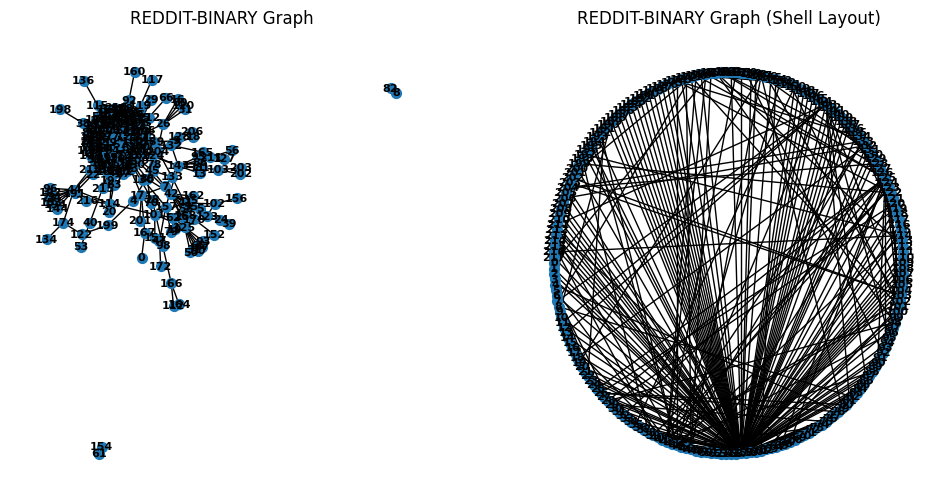

In [44]:
plot_dataset_net(REDDIT_G, first_graph_REDDIT_G)

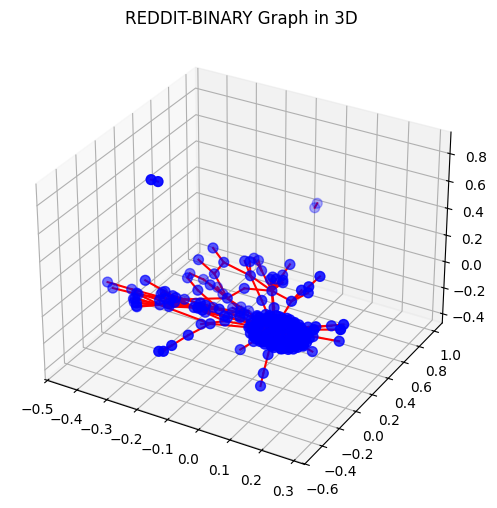

In [6]:
plot_dataset_net_3D(REDDIT_G, first_graph_REDDIT_G)

Get graph diameter which is the length of the shortest path between the most distanced nodes

In [7]:
#Function to get diameter

print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_diameter())

8


## Effective resistance

The effective resistance is measures how easily information flows between pairs of nodes. If rewiring reduces effective resistance, it improves communication efficiency:

$$[ R_{uv} = L^+{uu} + L^+{vv} - 2L^+_{uv} ]$$



where $R_{ij}$ is the resistance between nodes $i$ and $j$ in the graph.


In [8]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_eff_res())

3.0027688909524106


## Modularity

Quantifies how well the graph divides into clusters or communities. If rewiring disrupts modularity, it may indicate loss of local structure.

$$Q = \sum_{c=1}^{n}
       \left[ \frac{L_c}{m} - \gamma\left( \frac{k_c}{2m} \right) ^2 \right]$$

where the sum iterates over all communities $c$, $m$ is the number of edges, $L_c$ is the number of intra-community links for community $c$, $k_c$ is the sum of degrees of the nodes in community $c$, and $\gamma$ is the resolution parameter.

In [9]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_modularity())

0.5892013888888892


## Graph Assortativity

Measures if nodes tend to connect to others with similar degree. A change in assortativity indicates whether high/low-degree nodes are rewired differently.

$$r = \frac{\sum_{ij} ij (e_{ij} - q_i q_j)}{\sigma^2}$$

where $e_{ij}$ is the fraction of edges connecting nodes of degree $i$ and $j$, $q_i$ is the fraction of edges connected to nodes of degree $i$, and $\sigma^2$ is the variance of the degree distribution.

In [10]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_assort())

-0.4046069146077361


## Clustering Coefficient

Measures how likely a node’s neighbors are to be connected to each other. Increasing clustering after rewiring may improve local information sharing.

$$C = \frac{1}{n}\sum_{v \in G} c_v$$

where :math:`n` is the number of nodes in `G`.

In [11]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_clust_coeff())

0.04106324376158407


## Graph Laplacian Eigenvalues (Spectral Gap):

The second smallest eigenvalue (λ1\lambda_1λ1​) of the Laplacian indicates how well-connected the graph is. A larger spectral gap after rewiring suggests better robustness and connectivity.

ADD formula

where $f$ is a non-zero vector orthogonal to the all-ones vector $\mathbf{1}$, $L$ is the Laplacian matrix, and $f^T$ denotes the transpose of $f$.

In [12]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_spec_gap())

-6.122337539530589e-16


❗️ **NOTE:** above might be wrong btw

## Forman-Ricci curvature F(i,j)

A computationally simpler alternative to Ollivier-Ricci, used for edge-based curvature analysis. While F(i,j) is given in terms of combinatorial quantities, results are scarce and the definition is biased towards negative curvature.

In [13]:
# print(get_forman_curve(red_G))
print(get_Forman_curve(REDDIT_G))

0.0


An average curvature of 1.0 indicates that the graph red_G has a positive and moderately connected structure. The nodes tend to have low degrees, and the edges are part of well-connected regions, contributing to the overall robustness and connectivity of the graph

## Average Betweenness Centrality

In [14]:
print(GraphMetrics(REDDIT_G, first_graph_REDDIT_G).get_bet_cent())

0.009113830991605487


## Results of unrewired metrics methods

                           Metric         Value Dataset
0                        Diameter  8.000000e+00       R
1            Effective Resistance  3.002769e+00       R
2                      Modularity  5.892014e-01       R
3                   Assortativity -4.046069e-01       R
4          Clustering Coefficient  4.106324e-02       R
5                    Spectral Gap -6.122338e-16       R
6  Average Betweenness Centrality  9.113831e-03       R


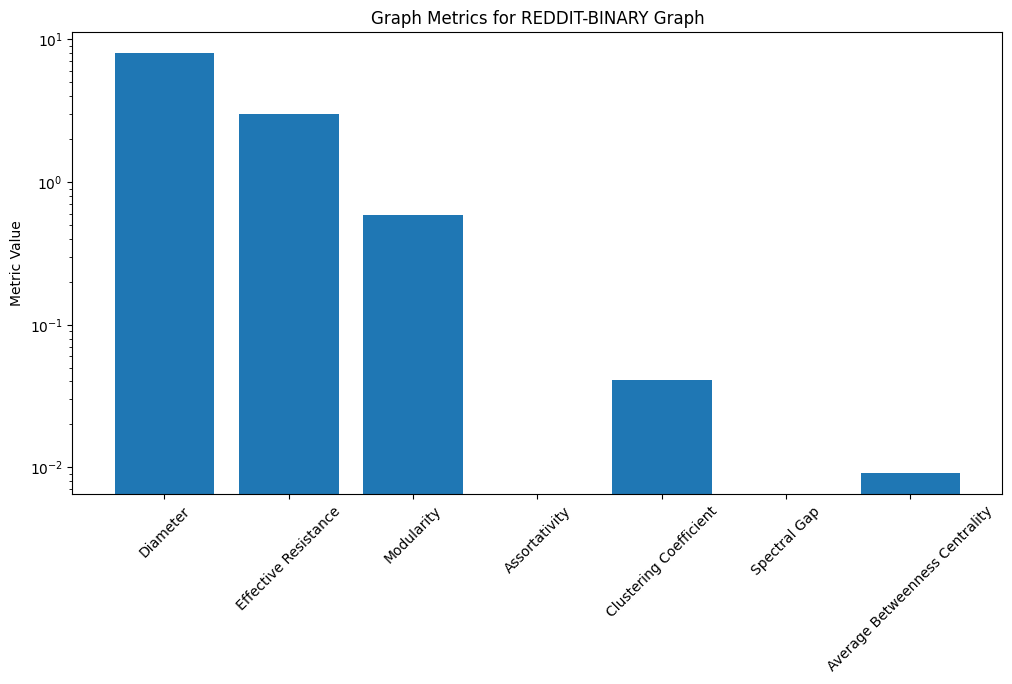

In [15]:
unrewired_metrics = GraphMetrics(REDDIT_G, first_graph_REDDIT_G)
values = unrewired_metrics.get_all_metrics()

# Get all metrics as a pandas DataFrame
df = unrewired_metrics.get_metrics_dataframe()
plot_metrics_histogram(values,first_graph_REDDIT_G, log = True)


----

# Rewiring our graphs

🚩 We need to respect the experimental details of hyperparameters describe on page 15

## BORF: Batch Ollivier-Ricci Flow

📎 Paper: [BORF](https://arxiv.org/pdf/2211.15779)

💻 Code: [BORF Github](https://github.com/hieubkvn123/revisiting-gnn-curvature)

In [5]:
from rewiring.borf.borf import *

dataset_names = ["MUTAG"]
# dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "BORF_1"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

all_metrics_df = []

# Loop through datasets and apply BORF rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")
    
    # Get first graph
    first_graph = dataset_loader.first_graphs[dataset_name]
    print("first graph", type(first_graph))

    # Get first graph from dataset
    # Ensure node features exist
    if not hasattr(first_graph, 'x') or first_graph.x is None:
        first_graph.x = torch.ones((first_graph.num_nodes, 1))
    print(f"📊 First graph from {dataset_name}: {first_graph}")
    print(first_graph) ## --> REDDIT-BINARY: Data(edge_index=[2, 480], y=[1], num_nodes=218)
    

    # Get original graph info (optional)
    original_graph = dataset_loader.get_graph_info(dataset_name, 0)

    # Apply BORF rewiring using borf3
    print(f"🔄 Applying BORF on {dataset_name}...")
    edge_index, edge_type = borf3(
        data=first_graph,
        loops=50,
        batch_add=4,
        batch_remove=2,
        is_undirected=True,
        device=None,  
        save_dir='rewired_graphs',
        dataset_name=dataset_name,
        graph_index=0,
        debug=True
    )

    # Convert the edge_index to NumPy and then NetworkX graph
    rewired_edge_index = edge_index.numpy().T
    rewired_G_borf = nx.Graph()
    rewired_G_borf.add_edges_from(rewired_edge_index)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_borf.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired = GraphMetrics(rewired_G_borf, dataset_name)
    df_metrics = metrics_rewired.get_metrics_dataframe()
    
    # Store and later save the metrics
    all_metrics_df.append(df_metrics)

final_df = pd.concat(all_metrics_df, ignore_index=True)
output_csv = f"{REWIRING_METHOD} rewired_graph_metrics_{dataset_name}.csv"
final_df[["Value"]].to_csv(f"results/{output_csv}", index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")


⚠️ Warning: 'MUTAG' not found. Did you mean 'MUTAG'?
✅ Dataset MUTAG already exists. Loading from disk...
✅ Converted 188 graphs from MUTAG into NetworkX format.

🚀 Processing dataset: MUTAG
first graph <class 'torch_geometric.data.data.Data'>
📊 First graph from MUTAG: Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

📊 **Graph 0 from MUTAG**:
- Nodes: 17, Edges: 19
- Number of classes: 2
- Features per Node: 7
- Graph Class Label: 1
🔄 Applying BORF on MUTAG...
[INFO] Rewired graph for 50 iterations, 4 edge additions and 2 edge removal exists...
✅ Rewiring complete! MUTAG now has 8 edges.
                           Metric     Value Dataset
0                        Diameter  3.000000   MUTAG
1                      Modularity  0.179688   MUTAG
2                   Assortativity -0.819549   MUTAG
3          Clustering Coefficient  0.000000   MUTAG
4                    Spectral Gap  0.345346   MUTAG
5  Average Betwee

/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/rewiring/borf/borf.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_index = torch.load(f)
/

## SDRF: Stochastic Discrete Ricci Flow

Curvature-based edge rewiring --> mitigate bottleneck effects

⚠️ Warning: 'IMDB-BINARY' not found. Did you mean 'IMDB-BINARY'?
✅ Dataset IMDB-BINARY already exists. Loading from disk...
✅ Converted 1000 graphs from IMDB-BINARY into NetworkX format.

🚀 Processing dataset: IMDB-BINARY
📊 First graph from IMDB-BINARY: Data(edge_index=[2, 146], y=[1], num_nodes=20)

📊 **Graph 0 from IMDB-BINARY**:
- Nodes: 20, Edges: 73
- Number of classes: 2
- Features per Node: 0
- Graph Class Label: 0
🔄 Applying SDRF on IMDB-BINARY...


/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/rewiring/sdrf/sdrf.py:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_edge_index = torch.tensor(new_edge_index)


✅ Rewiring complete! IMDB-BINARY now has 123 edges.
                           Metric     Value      Dataset
0                        Diameter  2.000000  IMDB-BINARY
1            Effective Resistance  0.150510  IMDB-BINARY
2                      Modularity  0.068973  IMDB-BINARY
3                   Assortativity  0.026773  IMDB-BINARY
4          Clustering Coefficient  0.854311  IMDB-BINARY
5                    Spectral Gap  0.381946  IMDB-BINARY
6  Average Betweenness Centrality  0.019591  IMDB-BINARY

📂 All rewiring results saved to SDRF rewired_graph_metrics_IMDB-BINARY.csv.


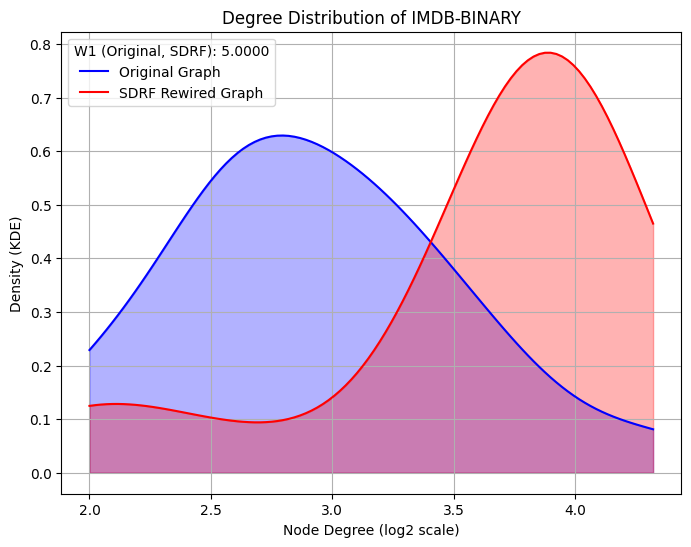

In [2]:

from rewiring.sdrf.sdrf import SDRFTransform

# Define dataset names
dataset_names = ["IMDB-BINARY"]
# dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "SDRF"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

# Load all datasets
dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

all_metrics_df = []

# Loop through all datasets and apply FOSR rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")

    # Get first graph
    first_graph = dataset_loader.first_graphs[dataset_name]
    print(f"📊 First graph from {dataset_name}: {first_graph}")

    # Get original graph info
    original_graph = dataset_loader.get_graph_info(dataset_name, 0)

    # Apply SDRF rewiring
    print(f"🔄 Applying SDRF on {dataset_name}...")
    sdrf = SDRFTransform(num_iterations=50, dataset=dataset_name)
    
    rewired_graph_sdrf = sdrf.transform(first_graph)
    
    # Extract rewired edges
    rewired_edge_sdrf_index = rewired_graph_sdrf.edge_index.numpy().T

    # Convert to NetworkX for evaluation
    rewired_G_sdrf = nx.Graph()
    rewired_G_sdrf.add_edges_from(rewired_edge_sdrf_index)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_sdrf.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired_sdrf = GraphMetrics(rewired_G_sdrf, dataset_name)
    df_metrics = metrics_rewired_sdrf.get_metrics_dataframe()
    
    # Store results
    all_metrics_df.append(df_metrics)

    # Combine results into a single DataFrame
    final_df = pd.concat(all_metrics_df, ignore_index=True)

# Save results to CSV
output_csv = f"{REWIRING_METHOD} rewired_graph_metrics_{dataset_name}.csv"
final_df[["Value"]].to_csv(f"results/{output_csv}", index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")

"""
plot the degree distribution of the original and rewired graph. The xaxis is node degree in log2
scale, and the plots are a kernel density estimate of the degree distribution.
In the captions we see the Wasserstein distance W1 between the original and preprocessed graphs
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde

# TODO: Move to a separate file and create a general accessible function

def degree_dist(G: nx.Graph):
    #if G is not a graph, raise an error
    if not isinstance(G, nx.Graph):
        raise ValueError("Input graph must be a NetworkX graph.")
    degrees = np.array([deg for _, deg in G.degree()])
    return degrees

def plot_degree_dist(G_og: nx.Graph, G_rw: nx.Graph, dataset_name: str, rw_method_name: str):
    degrees_og_graph = degree_dist(G_og)
    degrees_rw_graph = degree_dist(G_rw)
    
    # compute the Wasserstein distance
    W1_distance = wasserstein_distance(degrees_og_graph, degrees_rw_graph)
    
    # log2 transform
    degrees_og_graph = np.log2(degrees_og_graph+1)
    degrees_rw_graph = np.log2(degrees_rw_graph+1)
    
    # kernel density estimate
    kde_og = gaussian_kde(degrees_og_graph)
    kde_rw = gaussian_kde(degrees_rw_graph)
    
    x_vals = np.linspace(min(degrees_og_graph.min(), degrees_rw_graph.min()), 
                         max(degrees_og_graph.max(), degrees_rw_graph.max()), 100)
    
    
    # Plot KDE with fill
    plt.figure(figsize=(8, 6))
    plt.fill_between(x_vals, kde_og(x_vals), alpha=0.3, color="blue")
    plt.fill_between(x_vals, kde_rw(x_vals), alpha=0.3, color="red")

    # KDE Line Plots
    plt.plot(x_vals, kde_og(x_vals), label="Original Graph", color="blue")
    plt.plot(x_vals, kde_rw(x_vals), label="SDRF Rewired Graph", color="red")

    # Labels & Titles
    plt.xlabel("Node Degree (log2 scale)")
    plt.ylabel("Density (KDE)")
    plt.title("Degree Distribution of IMDB-BINARY")

    # Display Wasserstein Distance in the caption
    plt.legend(title=f"W1 (Original, {rw_method_name}): {W1_distance:.4f}")

    plt.grid(True)
    plt.show()
      

plot_degree_dist(original_graph, rewired_G_sdrf, dataset_name, REWIRING_METHOD)


## FOSR: First-order Spectral Reweighting

Spectral reweighting --> enhances spectral gap for better learning

**number of snapshots**:
- If no new edges were added, the edge weights remain the same.
- If num_snapshots = 1, all edges (old & new) are weighted equally (weight = 1).
- If num_snapshots = 2, new edges are weighted 2, differentiating them from the original

📌 Why Use Snapshots?
1. Distinguishing Rewired Edges
    - Allows experiments where new edges are tracked separately.
    - Helps understand the impact of rewiring on the graph structure.

2. Temporal Graphs / Evolving Graphs
    - If applied over time, snapshots can represent different states of a graph.
    - Useful in dynamic graphs like social networks or citation graphs.

3. Weighted Edge Importance

    - Different edge weights allow models to learn which edges contribute more to information flow.

In [ ]:
from rewiring.fosr.fosr import FOSRTransform

# Define dataset names
dataset_names = ["IMDB-BINARY"]
# dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "FOSR_imdb"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

# Load all datasets
dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

# Store results in a list
all_metrics_df = []

# Loop through all datasets and apply FOSR rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")

    # Get first graph
    first_graph = dataset_loader.first_graphs[dataset_name]
    print(f"📊 First graph from {dataset_name}: {first_graph}")

    # Get original graph info
    original_graph = dataset_loader.get_graph_info(dataset_name, 0)

    # Apply FOSR rewiring
    print(f"🔄 Applying FOSR on {dataset_name}...")
    fosr = FOSRTransform(num_snapshots=1, num_iterations=50, initial_power_iters=5, dataset=dataset_name)
    rewired_graph_fosr = fosr.transform(first_graph)

    # Extract rewired edges
    rewired_edge_fosr_index = rewired_graph_fosr.edge_index.numpy().T

    # Convert to NetworkX for evaluation
    rewired_G_fosr = nx.Graph()
    rewired_G_fosr.add_edges_from(rewired_edge_fosr_index)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_fosr.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired_fosr = GraphMetrics(rewired_G_fosr, dataset_name)
    df_metrics = metrics_rewired_fosr.get_metrics_dataframe()
    
    # Store results
    all_metrics_df.append(df_metrics)

    # Combine results into a single DataFrame
    final_df = pd.concat(all_metrics_df, ignore_index=True)

# Save results to CSV
output_csv = f"{REWIRING_METHOD} rewired_graph_metrics_{dataset_name}.csv"
final_df[["Value"]].to_csv(f"results/{output_csv}", index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")


⚠️ Warning: 'IMDB-BINARY' not found. Did you mean 'IMDB-BINARY'?
✅ Dataset IMDB-BINARY already exists. Loading from disk...
✅ Converted 1000 graphs from IMDB-BINARY into NetworkX format.

🚀 Processing dataset: IMDB-BINARY
📊 First graph from IMDB-BINARY: Data(edge_index=[2, 146], y=[1], num_nodes=20)

📊 **Graph 0 from IMDB-BINARY**:
- Nodes: 20, Edges: 73
- Number of classes: 2
- Features per Node: 0
- Graph Class Label: 0
🔄 Applying FOSR on IMDB-BINARY...
✅ Rewiring complete! IMDB-BINARY now has 123 edges.
                           Metric     Value Dataset
0                        Diameter  2.000000       I
1            Effective Resistance  0.140266       I
2                      Modularity  0.080607       I
3                   Assortativity -0.085887       I
4          Clustering Coefficient  0.711555       I
5                    Spectral Gap  0.658324       I
6  Average Betweenness Centrality  0.019591       I

📂 All rewiring results saved to FOSR_imdb rewired_graph_metrics_IMDB-BI

## DES: Double Edge Swap

Swap two edges in the graph while keeping the node degrees fixed: [NetworkX Double Edge Swap](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html)

In [ ]:
# Define dataset names
dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "DES"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

# Load all datasets
dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

# Store results in a list
all_metrics_df = []

# Loop through all datasets and apply FOSR rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")
    
    # Get first graph (ensure fresh copy)
    original_G = dataset_loader.get_graph_info(dataset_name, 0)

    # Ensure the graph is copied before applying rewiring (DES modifies in-place)
    rewired_G_des = original_G.copy()

    # Apply Double Edge Swap rewiring
    print(f"🔄 Applying Double Edge Swap on {dataset_name}...")
    nx.double_edge_swap(rewired_G_des, nswap=100, max_tries=500)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_des.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired_des = GraphMetrics(rewired_G_des, dataset_name)
    df_metrics = metrics_rewired_des.get_metrics_dataframe()
    
    # Store results
    all_metrics_df.append(df_metrics)

# Combine results into a single DataFrame
final_df = pd.concat(all_metrics_df, ignore_index=True)

# Save results to a SINGLE CSV file for all datasets
output_csv = f"{REWIRING_METHOD}_rewired_graph_metrics.csv"
final_df[["Value"]].to_csv(output_csv, index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")

## PPR: Personalized PageRank-based

Diffusion-Based Graph Rewiring

1. Personalized PageRank (PPR) diffusion → Spreads node influence through random walks.
2. Sparse Approximation (Top-K or Clipped Thresholding) → Retains only the most important edges.
3. Reconstructs Edge Index for PyTorch Geometric (PyG) → Outputs a new edge index based on PPR scores.

**🚀 What Type of Rewiring is This?**
| **Category** | **Technique** |
|-------------|--------------|
| **Diffusion-Based Rewiring** | **Personalized PageRank (PPR) Rewiring** |
| **Goal** | Improves **long-range message passing** in GNNs |
| **How?** | **Adds edges based on node influence** instead of structural properties |
| **Filtering** | Keeps only **top-K or high-weight** edges |

---
**🎯 When Should You Use This Rewiring?**
| **Scenario** | **Should You Use PPR Rewiring?** |
|-------------|------------------------|
| **Long-range dependencies needed?** | ✅ **YES** |
| **Over-squashing issue in GNNs?** | ✅ **YES** |
| **Preserving original structure?** | ❌ **NO** (Edges are re-weighted) |
| **Curvature-based methods needed?** | ❌ **NO** |

---
**✅ Summary**
- **Personalized PageRank (PPR) Rewiring** is a **graph diffusion technique**.
- **Edges are re-weighted** based on **node influence** instead of local structure.
- Helps **long-range dependencies** in **deep GNNs**.
- **Best used for improving information flow in GNNs**.

In [2]:
from rewiring.digl.digl import *

# Define dataset names
# dataset_names = ["REDDIT-BINARY"]
dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "PPR"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

# Load all datasets
dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

all_metrics_df = []

# Loop through all datasets and apply PPR rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")
    
    # Get first graph
    first_graph = dataset_loader.first_graphs[dataset_name]
    print("first graph", type(first_graph))

    # Get first graph from dataset
    # Ensure node features exist
    if not hasattr(first_graph, 'x') or first_graph.x is None:
        first_graph.x = torch.ones((first_graph.num_nodes, 1))
    print(f"📊 First graph from {dataset_name}: {first_graph}")
    print(first_graph) ## --> REDDIT-BINARY: Data(edge_index=[2, 480], y=[1], num_nodes=218)

    # Get original graph info
    original_graph = dataset_loader.get_graph_info(dataset_name, 0)

    # Apply PPR rewiring
    print(f"🔄 Applying PPR on {dataset_name}...")
    rewired_graph_ppr = rewire_digl(first_graph, alpha=0.1, k=128) # returns data.edge_index
        
    # Extract rewired edges
    rewired_edge_ppr_index = rewired_graph_ppr.edge_index.numpy().T

    # Convert to NetworkX for evaluation
    rewired_G_ppr = nx.Graph()
    rewired_G_ppr.add_edges_from(rewired_edge_ppr_index)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_ppr.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired_ppr = GraphMetrics(rewired_G_ppr, dataset_name)
    df_metrics = metrics_rewired_ppr.get_metrics_dataframe()
    
    # Store results
    all_metrics_df.append(df_metrics)

    # Combine results into a single DataFrame
    final_df = pd.concat(all_metrics_df, ignore_index=True)

# Save results to CSV
output_csv = f"{REWIRING_METHOD} rewired_graph_metrics_{dataset_name}.csv"
final_df[["Value"]].to_csv(f"results/{output_csv}", index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")

⚠️ Warning: 'REDDIT-BINARY' not found. Did you mean 'REDDIT-BINARY'?
✅ Dataset REDDIT-BINARY already exists. Loading from disk...
✅ Converted 2000 graphs from REDDIT-BINARY into NetworkX format.
⚠️ Warning: 'IMDB-BINARY' not found. Did you mean 'IMDB-BINARY'?
✅ Dataset IMDB-BINARY already exists. Loading from disk...
✅ Converted 1000 graphs from IMDB-BINARY into NetworkX format.
⚠️ Warning: 'MUTAG' not found. Did you mean 'MUTAG'?
✅ Dataset MUTAG already exists. Loading from disk...
✅ Converted 188 graphs from MUTAG into NetworkX format.
⚠️ Warning: 'ENZYMES' not found. Did you mean 'ENZYMES'?
✅ Dataset ENZYMES already exists. Loading from disk...
✅ Converted 600 graphs from ENZYMES into NetworkX format.
⚠️ Warning: 'PROTEINS' not found. Did you mean 'PROTEINS'?
✅ Dataset PROTEINS already exists. Loading from disk...
✅ Converted 1113 graphs from PROTEINS into NetworkX format.

🚀 Processing dataset: REDDIT-BINARY
first graph <class 'torch_geometric.data.data.Data'>
📊 First graph from RE

/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


                           Metric     Value   Dataset
0                        Diameter  1.000000  PROTEINS
1            Effective Resistance  0.047619  PROTEINS
2                      Modularity  0.022702  PROTEINS
3                   Assortativity       NaN  PROTEINS
4          Clustering Coefficient  1.000000  PROTEINS
5                    Spectral Gap  1.024390  PROTEINS
6  Average Betweenness Centrality  0.000000  PROTEINS

📂 All rewiring results saved to PPR rewired_graph_metrics_PROTEINS.csv.


/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


## LASER: Locality-Aware Graph Rewiring in GNNs

⚠️ Warning: 'ENZYMES' not found. Did you mean 'ENZYMES'?
✅ Dataset ENZYMES already exists. Loading from disk...
✅ Converted 600 graphs from ENZYMES into NetworkX format.

🚀 Processing dataset: ENZYMES
📊 First graph from ENZYMES: Data(edge_index=[2, 168], x=[37, 3], y=[1])

📊 **Graph 0 from ENZYMES**:
- Nodes: 37, Edges: 84
- Number of classes: 6
- Features per Node: 3
- Graph Class Label: 5
🔄 Applying LASER on ENZYMES...
Data(edge_index=[2, 168], x=[37, 3], y=[1, 6], dataset_name='ENZYMES')
Fixing shape mismatch: torch.Size([168, 1]) vs. torch.Size([1164, 1])
✅ Rewiring complete! ENZYMES now has 666 edges.
                           Metric     Value  Dataset
0                        Diameter  1.000000  ENZYMES
1            Effective Resistance  0.054054  ENZYMES
2                      Modularity  0.000000  ENZYMES
3                   Assortativity       NaN  ENZYMES
4          Clustering Coefficient  1.000000  ENZYMES
5                    Spectral Gap  1.027778  ENZYMES
6  Average Betw

/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


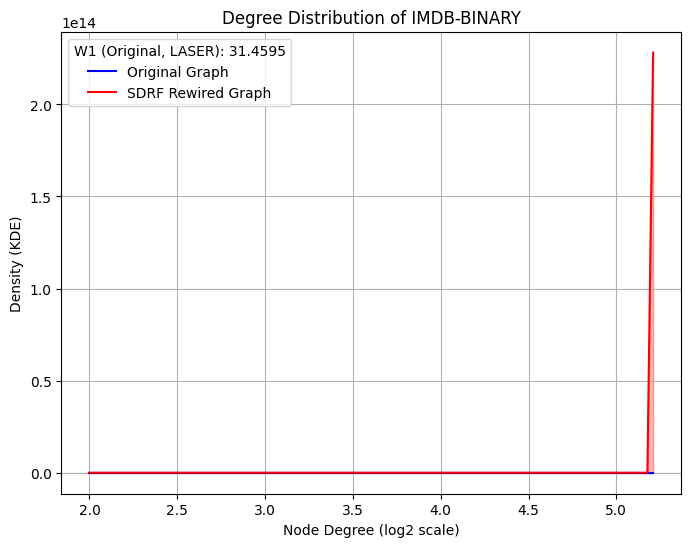

In [ ]:

from rewiring.laser.laser import LaserGlobalTransform

# Define dataset names
dataset_names = ["ENZYMES"]
# dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
REWIRING_METHOD = "LASER"

# "REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"

# Load all datasets
dataset_loader = GraphDatasetLoader(dataset_names, edge_attr=True)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

all_metrics_df = []

# Loop through all datasets and apply LASER rewiring
for dataset_name in loaded_datasets:
    print(f"\n🚀 Processing dataset: {dataset_name}")

    # Get first graph
    first_graph = dataset_loader.first_graphs[dataset_name]
    print(f"📊 First graph from {dataset_name}: {first_graph}")
    
    # add the dataset_name to the first_graph object
    first_graph.dataset_name = dataset_name

    # Get original graph info
    original_graph = dataset_loader.get_graph_info(dataset_name, 0)

    # Apply LASER rewiring
    print(f"🔄 Applying LASER on {dataset_name}...")
    laser = LaserGlobalTransform(dataset=dataset_name)
    
    rewired_graph_laser = laser.transform(first_graph)
    
    # Extract rewired edges
    rewired_edge_laser_index = rewired_graph_laser.edge_index.numpy().T

    # Convert to NetworkX for evaluation
    rewired_G_laser = nx.Graph()
    rewired_G_laser.add_edges_from(rewired_edge_laser_index)

    print(f"✅ Rewiring complete! {dataset_name} now has {rewired_G_laser.number_of_edges()} edges.")

    # Compute metrics for the rewired graph
    metrics_rewired_laser = GraphMetrics(rewired_G_laser, dataset_name)
    df_metrics = metrics_rewired_laser.get_metrics_dataframe()
    
    # Store results
    all_metrics_df.append(df_metrics)

    # Combine results into a single DataFrame
    final_df = pd.concat(all_metrics_df, ignore_index=True)

# Save results to CSV
output_csv = f"{REWIRING_METHOD} rewired_graph_metrics_{dataset_name}.csv"
final_df[["Value"]].to_csv(f"results/{output_csv}", index=False)
print(f"\n📂 All rewiring results saved to {output_csv}.")

"""
plot the degree distribution of the original and rewired graph. The xaxis is node degree in log2
scale, and the plots are a kernel density estimate of the degree distribution.
In the captions we see the Wasserstein distance W1 between the original and preprocessed graphs
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde

# TODO: Move to a separate file and create a general accessible function

def degree_dist(G: nx.Graph):
    #if G is not a graph, raise an error
    if not isinstance(G, nx.Graph):
        raise ValueError("Input graph must be a NetworkX graph.")
    degrees = np.array([deg for _, deg in G.degree()])
    return degrees

def plot_degree_dist(G_og: nx.Graph, G_rw: nx.Graph, dataset_name: str, rw_method_name: str):
    degrees_og_graph = degree_dist(G_og)
    degrees_rw_graph = degree_dist(G_rw)
    
    # compute the Wasserstein distance
    W1_distance = wasserstein_distance(degrees_og_graph, degrees_rw_graph)
    
    # log2 transform
    degrees_og_graph = np.log2(degrees_og_graph+1)
    degrees_rw_graph = np.log2(degrees_rw_graph+1)
    
    # kernel density estimate
    kde_og = gaussian_kde(degrees_og_graph)
    kde_rw = gaussian_kde(degrees_rw_graph)
    
    x_vals = np.linspace(min(degrees_og_graph.min(), degrees_rw_graph.min()), 
                         max(degrees_og_graph.max(), degrees_rw_graph.max()), 100)
    
    
    # Plot KDE with fill
    plt.figure(figsize=(8, 6))
    plt.fill_between(x_vals, kde_og(x_vals), alpha=0.3, color="blue")
    plt.fill_between(x_vals, kde_rw(x_vals), alpha=0.3, color="red")

    # KDE Line Plots
    plt.plot(x_vals, kde_og(x_vals), label="Original Graph", color="blue")
    plt.plot(x_vals, kde_rw(x_vals), label=f"{rw_method_name} Rewired Graph", color="red")

    # Labels & Titles
    plt.xlabel("Node Degree (log2 scale)")
    plt.ylabel("Density (KDE)")
    plt.title(f"Degree Distribution of {rw_method_name}")

    # Display Wasserstein Distance in the caption
    plt.legend(title=f"W1 (Original, {rw_method_name}): {W1_distance:.4f}")

    plt.grid(True)
    plt.show()
      
plot_degree_dist(original_graph, rewired_G_laser, dataset_name, REWIRING_METHOD)
